# Importing tables and getting them into the correct format
Required packages are: <br />
Pandas <br />
Numpy <br />
Mathplotlib <br />
sklearn <br />
Collections <br />
imbleran (has to be version 0.62)<br />
scipy  <br />

# Load packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from collections import Counter
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import mode

# Load data and convert it to one-hot-encoding format

In [6]:
#Convert data in one-hot-encoding format
#Get unique values from all the columns
Data = pd.read_csv('./Data/MC_Results_Processed.csv',sep=',')
def Get_unique_values(DF):
    #remove the contestant name and season
    DF = DF[DF.columns[2:-1]]
    unique_list = []
    for i in range(len(DF.columns)):
        col_name = DF.columns[i]
        Unique_entry = pd.unique(DF[col_name])
        for j in Unique_entry:
            if j not in unique_list:
                unique_list.append(j)
        else:
            pass
    return unique_list

def Get_unique_labels(df):
    lables = df[df.columns[-1]]
    unique_labels = pd.unique(lables)
    return np.array(unique_labels)
Get_unique_labels(Data)
Unique_Entries = Get_unique_values(Data)
Unique_lables= Get_unique_labels(Data)
Lables = Data[Data.columns[-1]]


#Use unique Entries and lables to convert to one-hot-encoding
def encode_labels(Data,Unique_lables):
    Label = Data[Data.columns[-1]]
    List = []
    for i in Label:
        Bool_Vector = i == np.array(Unique_lables)
        Hot_encoded_vector = Bool_Vector * np.ones(np.shape(Bool_Vector))
        List.append(Hot_encoded_vector)
    List = np.vstack(List)
    return List   


def Unique_Features(Data):
    DF = Data
    DF = DF[DF.columns[2:-1]]
    List = []
    for i in range(len(DF)):
        Row_core = DF.iloc[i]
        row = Row_core.to_frame().T
        row_values= row.values.tolist()
        for j in range(len(DF.columns)):
            Entry = row_values[0][j]
            if Entry not in List:
                List.append(Entry)
            else:
                pass
    return np.array(List) 

def Hot_encode_x(DF,Unique_Entries):
    '''Input the Data including paritciplants name and lable and will 
    output a list within a list representing the rows. 
    Inside these row list are arrays of the hot-encoded features'''
    DF = DF[DF.columns[2:-1]]
    List =[]
    for i in range(len(DF)):
        Row_list = []
        Row_core = DF.iloc[i]
        row = Row_core.to_frame().T
        row_values= row.values.tolist()
        for j in range(len(DF.columns)):
            Entry = row_values[0][j]
            Bool_vector = Entry == np.array(Unique_Entries)
            Hot_encode_vector = np.array(Bool_vector) * np.ones(np.shape(Unique_Entries))
            Row_list.append(Hot_encode_vector)
        List.append(Row_list)
    Array_List = []
    for i in range(len(List)):
        row = List[i]
        array = np.concatenate(row)
        Array_List.append(array)
    X_vector = np.vstack(Array_List)
    return X_vector



There are 13 different catagorical features used to measure contestant performance in challenges. 

| Entry | Meaning |
| --- | --- | 
|Btm | Contestant performance was in the "bottom" group
|Elim | Contestant did not compete due to elimination|
|IN | Contestant did perform in the challenge|
|Immune | Contestant did not perform as they are "immune" that round|
|Lose | The contestant lost the challenge|
|None | Contestant did not perform in the challenge|
|Team 2nd | Team challenge where the contestant was apart of the second placed team|
|Team 3rd | Team challenge where the contestant was apart of the third placed team|
|Team Lose | Team challenge where the contestant was apart of the team that placed last|
|Team Win | Team challenge where the contestant was apart of the winning team|
|Top| The contestant scored in the top portion of contestants|
|Win | The contestant won the challenge|


In [7]:
#Get all the unique entries to perform one-hot encoding (OHE)
#import data
Unique_Y_lables = Get_unique_labels(Data)
Unique_Features = Get_unique_values(Data)
X_Vector = Hot_encode_x(Data,Unique_Features)
Y_Vector = encode_labels(Data,Unique_Y_lables)

# Split data into training,cross-validation and test set

In [8]:
#Data was in order so need to randomise the data
Shuffle = Data.sample(frac=1,random_state = 1) #Shuffle data dividing it into 1 fraction, with seed = 1
Shuffle.reset_index(drop=True, inplace=True)

Test_index =[]
Cross_index= []
Train_index =[]
for i in range(len(Shuffle)):
    if (i/len(Shuffle)) <= 0.5:
        Train_index.append(i)
    elif ((i/len(Shuffle)) > 0.5 and (i/len(Shuffle)) <= 0.75):
        Cross_index.append(i)
    else:
        Test_index.append(i)
        
Train_data = Shuffle[Shuffle.index.isin(Train_index)]
Cross_data = Shuffle[Shuffle.index.isin(Cross_index)]
Test_data = Shuffle[Shuffle.index.isin(Test_index)]

In [9]:
#Create x test vector and partial training vector (need to add the oversampled data)
Train_Y_Vector_partial = encode_labels(Train_data,Unique_lables)
Train_X_Vector_partial = Hot_encode_x(Train_data,Unique_Features)

Y_Cross = encode_labels(Cross_data,Unique_lables)
X_Cross = Hot_encode_x(Cross_data,Unique_Features)

Y_Test = encode_labels(Test_data,Unique_lables)
X_Test = Hot_encode_x(Test_data,Unique_Features)

# Oversampling

In [10]:
#convert one hot encoded to catagory [0:4]
Y_catagory = np.zeros(np.shape(Train_Y_Vector_partial)[0])
for i in np.arange(len(Train_Y_Vector_partial )):
    Y_catagory[i] = np.argmax(Train_Y_Vector_partial [i])
#We want to oversample all catagories, even the majority class. To achieve this we will perform oversampling with a fake majority class
X_Fake = np.zeros((2000,np.shape(Train_X_Vector_partial)[1]))
Y_Fake = 5* np.ones((2000))
#Combine real and fake data
X_Fake_and_Real = np.vstack((Train_X_Vector_partial,X_Fake))
Y_Fake_and_Real = np.hstack((Y_catagory,Y_Fake))

In [11]:
smote_nc = SMOTENC(categorical_features=[0, 5], random_state=1,k_neighbors=3) #set seed to 1
Fake_Oversampled_X, Fake_Oversampled_Y = smote_nc.fit_resample(X_Fake_and_Real, Y_Fake_and_Real)
print(sorted(Counter(Fake_Oversampled_Y).items()))

[(0.0, 2000), (1.0, 2000), (2.0, 2000), (3.0, 2000), (5.0, 2000)]


In [12]:
End_of_real_data = np.min(np.where(Fake_Oversampled_Y == 5))
Only_Fake_Oversampled_X = Fake_Oversampled_X[End_of_real_data:,:]
Only_Fake_Oversampled_Y = Fake_Oversampled_Y[End_of_real_data:]
#Remove the fake 5 catagorical data from the oversampled
Index_2_remove = np.where(Only_Fake_Oversampled_Y == 5)
Oversampled_Y = Only_Fake_Oversampled_Y[2000:]
Oversampled_X = Only_Fake_Oversampled_X[2000:,:]# We can't include the oversampled data in the test set as its arteficial. We need to separate out the oversampled data
#We do this with the fake 5 catagory section. 
End_of_real_data = np.min(np.where(Fake_Oversampled_Y == 5))
Only_Fake_Oversampled_X = Fake_Oversampled_X[End_of_real_data:,:]
Only_Fake_Oversampled_Y = Fake_Oversampled_Y[End_of_real_data:]
#Remove the fake 5 catagorical data from the oversampled
Index_2_remove = np.where(Only_Fake_Oversampled_Y == 5)
Oversampled_Y = Only_Fake_Oversampled_Y[2000:]
Oversampled_X = Only_Fake_Oversampled_X[2000:,:]

#Get Oversampled_Y back into OHE format
Temp_array = np.zeros((len(Oversampled_Y),len(Unique_lables)))
for i in np.arange(len(Oversampled_Y)):
    OHE_Index = (Oversampled_Y[i])
    Temp_array[i][int(OHE_Index)] = 1
Oversampled_Y = Temp_array

X_Train = np.vstack((Train_X_Vector_partial,Oversampled_X))
Y_Train = np.vstack((Train_Y_Vector_partial,Oversampled_Y))


def OHE_to_catagory(OHE_Y_Vector):  
    Temp_array = 6* np.ones(np.shape(OHE_Y_Vector)[0])
    for i in np.arange(len(OHE_Y_Vector)):
        Temp_array[i] = np.argmax(OHE_Y_Vector[i])
    return Temp_array

Y_Test_catagory = OHE_to_catagory(Y_Test)

# Priciple Component analysis

One-hot-encoding carries the disadvantage that it greatly increases the number of attributes. To compensate for this, PCA will be performed to reduce the number of features so that only those that are informative will remain. This is particularly effective in this scenario as most of the features produced in the encoding are 0 and therefore uninformative.

In [13]:
#Perform PCA on data
def PCA(X_vector):
    Size = len(X_vector)
    mu = np.mean(X_vector, axis=0)
    Covar = 1.0 / (Size-1) * np.dot((X_vector-mu).T, (X_vector-mu))
    # Perform eigendecomposistion
    E_vec,E_val = np.linalg.eigh(Covar)
    E_vec = E_vec[::-1]
    E_val =E_val[:, ::-1]
    return E_val, E_vec    

In [14]:
Eigen_Vec,Eigen_Val = PCA(X_Vector)

Text(0, 0.5, 'Eigenvalue')

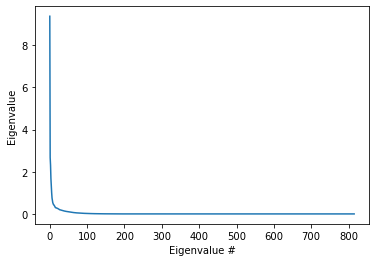

In [15]:
plt.plot(Eigen_Val)
plt.xlabel('Eigenvalue #')
plt.ylabel('Eigenvalue')

In [16]:
#Select n eigen values to account for 95% of variation
Eigen_percent = Eigen_Val/np.sum(Eigen_Val)
Principle_eigen_vals = np.zeros(1)
for i in np.arange(len(Eigen_percent)):
    if i == 0:
        Principle_eigen_vals[i] = Eigen_percent[i]
    else: 
        Principle_eigen_vals = np.hstack((Principle_eigen_vals,Eigen_percent[i]))
    if np.sum(Principle_eigen_vals) >= 0.95:
        break
d=len(Principle_eigen_vals)
print("The first",d, "eigenvectors make up 90% of the variance in the data")

The first 72 eigenvectors make up 90% of the variance in the data


In [17]:
Principle_components = Eigen_Vec[:, 0:d]
np.shape(Principle_components)

(816, 72)

# Reduce dimensions of different datasets and Augment data

In [18]:
Reduced_X_Train = np.dot((X_Train - np.mean(X_Vector,axis=0)), Principle_components) 
Reduced_X_Cross = np.dot((X_Cross - np.mean(X_Vector,axis=0)), Principle_components) 
Reduced_X_Test = np.dot((X_Test- np.mean(X_Vector,axis=0)), Principle_components) 

In [19]:
#Augment the text vectors
X_Train_aug = np.hstack((np.ones((np.shape(Reduced_X_Train)[0],1)),Reduced_X_Train))
X_Cross_aug = np.hstack((np.ones((np.shape(Reduced_X_Cross)[0],1)),Reduced_X_Cross))
X_Test_aug = np.hstack((np.ones((np.shape(Reduced_X_Test)[0],1)),Reduced_X_Test))

# Initialise theta vector

In [20]:
theta_vector = np.zeros((np.shape(X_Test_aug)[1],len(Unique_lables)))
print(np.shape(theta_vector))

(73, 4)


# Logistic regression model

In [21]:
def h(x,theta):
    return 1/(1 + np.exp(-np.dot(x,theta)))

In [22]:
def Train_logistic(x,y,theta_inital,alpha,epsilon,lam):
    Total_mean_error = []
    N = np.shape(x)[0]
    theta = np.copy(theta_inital)
    reg = 1-(alpha*(lam/N))
    converged = False
    while not converged:
        Output = h(x,theta)
        Error = (Output - y)
        Derivative_h = Output * (1-Output) * Error
        Mean_sqr_error = (1/2*N) * np.sum(Error**2,axis =1)
        Mean_error = np.mean(Mean_sqr_error,axis=0)
        Total_mean_error.append(Mean_error)
        prev_theta = theta.copy()
        #update theta using regularisation
        theta[0] = theta[0] - (alpha/N) * np.dot(x[:,0].T,Derivative_h)
        theta[1:] = theta[1:]*reg - (alpha/N) * np.dot(x[:,1:].T,Derivative_h)
        if np.max(theta - prev_theta) <= epsilon:
            converged = True
    return theta, Total_mean_error  

In [23]:
def predict(x_Test, theta):
    Temp_array = 6* np.ones(np.shape(x_Test)[0])
    Output = h(x_Test,theta)
    for i in np.arange(len(x_Test)):
        Temp_array[i] = np.argmax(Output[i])
    return Temp_array

# Tune hyper parameters 
Tune alpha

In [24]:
Y_test_cat = OHE_to_catagory(Y_Test)

In [25]:
alpha_range = np.arange(0,0.25,0.001)
Range = np.arange(len(alpha_range))
Alpha_Accuracy = np.zeros(len(alpha_range))
for i in Range:
    theta, error = Train_logistic(X_Cross_aug,Y_Cross,theta_vector,alpha_range[i],epsilon=0.0005,lam=0)#turn off regularisation
    Y_predicted = predict(X_Test_aug,theta)
    Y_predicted = predict(X_Test_aug,theta)
    accuracy_temp = metrics.f1_score(Y_test_cat,Y_predicted,average='weighted')
    Alpha_Accuracy[i] = accuracy_temp

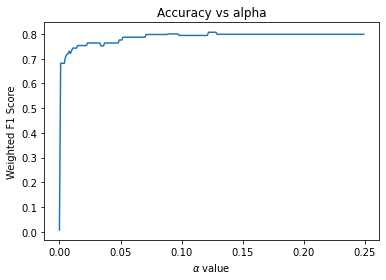

In [26]:
plt.figure()
plt.plot(alpha_range,Alpha_Accuracy)
plt.xlabel(r'$ \alpha $ value')
plt.ylabel('Weighted F1 Score')
plt.title('Accuracy vs alpha');

In [27]:
Optimal_alpha = alpha_range[np.argmax(Alpha_Accuracy)]
Optimal_alpha

0.122

Tune Lamda

In [28]:
lam_range = np.arange(0,1000,50)
Range = np.arange(len(lam_range))
Lam_Accuracy = np.zeros(len(lam_range))
for i in Range:
    theta, error = Train_logistic(X_Cross_aug,Y_Cross,theta_vector,Optimal_alpha,epsilon=0.0005,lam = lam_range[i])
    accuracy_temp = metrics.f1_score(Y_test_cat,Y_predicted,average='weighted')
    Lam_Accuracy[i] = accuracy_temp

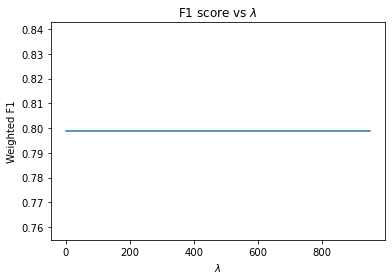

In [29]:
plt.figure()
plt.plot(lam_range,Lam_Accuracy)
plt.xlabel(r'$ \lambda $')
plt.ylabel('Weighted F1')
plt.title('F1 score vs 'r'$ \lambda $');

In [30]:
Optimal_lam = 0

Although regularisation was implenented there does not seem to be any change to performance through tuning the lamda hyper-parameter. Therefore, regularisation will be switched off for any subsequent training.

# Train classifier

In [31]:
theta, error = Train_logistic(X_Train_aug,Y_Train,theta_vector,alpha=Optimal_alpha,epsilon=0.0005,lam=Optimal_lam)

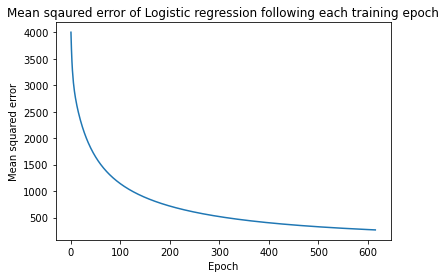

In [32]:
plt.figure()
plt.plot(np.arange(len(error)),error)
plt.title('Mean sqaured error of Logistic regression following each training epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error');

# Determine accuracy of logistic regression classifier

In [33]:
Log_predicted = predict(X_Test_aug,theta)
print(metrics.classification_report(Y_test_cat,Log_predicted))
print(metrics.confusion_matrix(Y_test_cat,Log_predicted))

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         4
         1.0       0.20      0.33      0.25         3
         2.0       0.64      0.82      0.72        11
         3.0       1.00      0.91      0.95        46

    accuracy                           0.84        64
   macro avg       0.63      0.64      0.62        64
weighted avg       0.88      0.84      0.86        64

[[ 2  2  0  0]
 [ 1  1  1  0]
 [ 0  2  9  0]
 [ 0  0  4 42]]


In [34]:
print("Precision:",metrics.precision_score(Y_test_cat,Log_predicted,average='weighted'))
print("Recall: ",metrics.recall_score(Y_test_cat,Log_predicted,average='weighted'))
print("F1: ",metrics.f1_score(Y_test_cat,Log_predicted,average='weighted'))

Precision: 0.880282738095238
Recall:  0.84375
F1:  0.8572625811688311


# KNN

In [35]:
def distance(x_vector,point):
    a = (x_vector - point)**2
    b = np.sum(a,axis =1)
    dist = np.sqrt(b)
    return dist
def KNN(x,y,predict,k):
    y = y.astype('int64')
    dist = distance(x,predict)  #calculate distance
    K_indexes = dist.argsort()[:k] 
    Y_value = y[K_indexes]
    if k == 1:
        Predicted = Y_value
    else:
        counts = np.bincount(Y_value)
        Predicted = np.argmax(counts)
    return Predicted

In [36]:
#Convert OHE labels into catagories
Y_Train_catagory = OHE_to_catagory(Y_Train)
Y_Test_catagory = OHE_to_catagory(Y_Test)

#  Tune hyper parameter K

Determine the error for the training dataset

In [37]:
#Warning ! Running this code will take a long time to run
x= Reduced_X_Train
y= Y_Train_catagory
N = len(Reduced_X_Train)
k = np.arange(90,120,2)
Train_output = np.zeros((len(k),1))
for K_index in np.arange(len(k)):
    y_predicted = 5*(np.ones((np.shape(y))))
    for i in np.arange(len(x)):
        datum = x[i]
        y_predict = KNN(x,y,datum,k[K_index])
        y_predicted[i] = y_predict
    error = (1/N) *np.sum(y_predicted != y)
    Train_output[K_index,[0]] = error

Determine the error for the testing dataset

In [38]:
Y_Cross_Catagory = OHE_to_catagory(Y_Cross)
x= Reduced_X_Cross
y= Y_Cross_Catagory
N = len(Reduced_X_Cross)
k = np.arange(90,120,2)
Cross_output = np.zeros((len(k),1))
for K_index in np.arange(len(k)):
    y_predicted = 5*(np.ones((np.shape(y))))
    for i in np.arange(len(x)):
        datum = x[i]
        y_predict = KNN(Reduced_X_Train,Y_Train_catagory,datum,k[K_index])
        y_predicted[i] = y_predict
    error = (1/N) *np.sum(y_predicted != y)
    Cross_output[K_index,[0]] = error

In [39]:
#Find the optimal K 
K_error = abs(np.array(Train_output)-np.array(Cross_output))
Optimal_K = k[np.argmin(abs(np.array(Train_output)-np.array(Cross_output)))]
Optimal_K

108

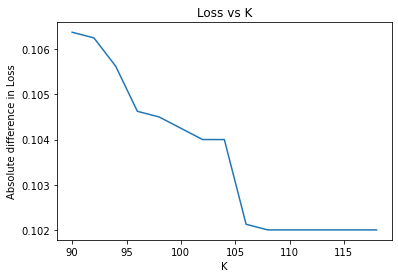

In [40]:
plt.figure()
plt.plot(k,K_error)
plt.xlabel('K')
plt.ylabel('Absolute difference in Loss')
plt.title('Loss vs K');

Predict Test data set using KNN model with optimal K

In [41]:
KNN_predicted = 5*np.ones((np.shape(X_Test)[0],1))
for i in np.arange(len(KNN_predicted)):
    KNN_Temp = KNN(x=Reduced_X_Train,y=Y_Train_catagory,predict=Reduced_X_Test[i],k=Optimal_K)
    KNN_predicted[i] = KNN_Temp

In [42]:
print(metrics.classification_report(Y_test_cat,KNN_predicted))
print(metrics.confusion_matrix(Y_test_cat,KNN_predicted))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.20      0.33      0.25         3
         2.0       0.67      0.55      0.60        11
         3.0       0.93      0.93      0.93        46

    accuracy                           0.81        64
   macro avg       0.58      0.58      0.57        64
weighted avg       0.83      0.81      0.82        64

[[ 2  2  0  0]
 [ 2  1  0  0]
 [ 0  2  6  3]
 [ 0  0  3 43]]


In [43]:
print("Precision: ",metrics.precision_score(Y_test_cat,KNN_predicted,average='weighted'))
print("Recall: ",metrics.recall_score(Y_test_cat,KNN_predicted,average='weighted'))
print("F1: ",metrics.f1_score(Y_test_cat,KNN_predicted,average='weighted'))

Precision:  0.8270833333333334
Recall:  0.8125
F1:  0.81796875


# XG Boost

Tune lamda

In [44]:
#Warning ! Running this code will take a long time to run
XG_lam_range = np.arange(0.1,1.1,0.1)
XG_Accuracy = []
for i in np.arange(len(XG_lam_range)):
    XGBoost_temp = GradientBoostingClassifier(random_state=0,learning_rate=XG_lam_range[i])
    XGBoost_temp.fit(X_Train, Y_Train_catagory)
    XG_predicted = XGBoost_temp.predict(X_Cross)
    Accuracy_temp = metrics.f1_score(Y_Cross_Catagory,XG_predicted,average='weighted')
    XG_Accuracy.append(Accuracy_temp)

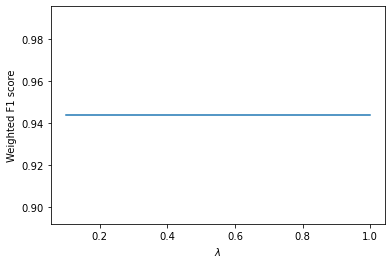

In [45]:
plt.figure()
plt.plot(XG_lam_range,XG_Accuracy)
plt.xlabel(r'$ \lambda $')
plt.ylabel('Weighted F1 score');

In [46]:
XG_Optimal_Lam =  XG_lam_range[np.argmax(XG_Accuracy)]
XG_Optimal_Lam

0.1

Confusion matrix for XGboost on cross-validation data to see why accuracy was so high

In [47]:
XGBoost_Cross = GradientBoostingClassifier(random_state=0,learning_rate=XG_Optimal_Lam)
XGBoost_Cross.fit(X_Train, Y_Train_catagory)
XG_predicted = XGBoost_Cross.predict(X_Cross)

In [48]:
print(metrics.classification_report(Y_Cross_Catagory,XG_predicted))
print(metrics.confusion_matrix(Y_Cross_Catagory,XG_predicted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      0.25      0.40         4
         2.0       0.67      1.00      0.80         6
         3.0       1.00      1.00      1.00        53

    accuracy                           0.95        64
   macro avg       0.92      0.81      0.80        64
weighted avg       0.97      0.95      0.94        64

[[ 1  0  0  0]
 [ 0  1  3  0]
 [ 0  0  6  0]
 [ 0  0  0 53]]


In [49]:
print("Precision: ",metrics.precision_score(Y_Cross_Catagory,XG_predicted,average='weighted'))
print("Recall: ",metrics.recall_score(Y_Cross_Catagory,XG_predicted,average='weighted'))
print("F1: ",metrics.f1_score(Y_Cross_Catagory,XG_predicted,average='weighted'))

Precision:  0.96875
Recall:  0.953125
F1:  0.94375


Train model and predict outcome in test data for XGboost model

In [50]:
XGBoost = GradientBoostingClassifier(random_state=0,learning_rate=XG_Optimal_Lam)
XGBoost.fit(X_Train, Y_Train_catagory)
XG_predicted = XGBoost.predict(X_Test)

Determine accuacy of the fitted model

In [51]:
print(metrics.classification_report(Y_test_cat,XG_predicted))
print(metrics.confusion_matrix(Y_test_cat,XG_predicted))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.00      0.00      0.00         3
         2.0       0.53      0.73      0.62        11
         3.0       0.98      0.91      0.94        46

    accuracy                           0.81        64
   macro avg       0.50      0.54      0.51        64
weighted avg       0.82      0.81      0.82        64

[[ 2  1  1  0]
 [ 1  0  2  0]
 [ 1  1  8  1]
 [ 0  0  4 42]]


In [52]:
print("Precision: ",metrics.precision_score(Y_test_cat,XG_predicted,average='weighted'))
print("Recall: ",metrics.recall_score(Y_test_cat,XG_predicted,average='weighted'))
print("F1: ",metrics.f1_score(Y_test_cat,XG_predicted,average='weighted'))

Precision:  0.8249515503875969
Recall:  0.8125
F1:  0.8153900172860846


# Bagging strategy using Logistic regression, KNN and XGBoost

In [53]:
#Create a vector that contains all the predicted results
All_predicted = np.hstack((Y_predicted.reshape((np.shape(Y_predicted)[0],1)),
                           np.hstack((KNN_predicted.reshape((np.shape(KNN_predicted)[0],1)),
                                      XG_predicted.reshape((np.shape(XG_predicted)[0],1))))))

In [54]:
Bag_predicted = np.ones(len(All_predicted))
for i in np.arange(len(Bag_predicted)):
    MODE = mode(All_predicted[i])
    Bag_predicted[i] = MODE[0]

In [55]:
print(metrics.classification_report(Y_test_cat,Bag_predicted))
print(metrics.confusion_matrix(Y_test_cat,Bag_predicted))

              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.25      0.33      0.29         3
         2.0       0.67      0.73      0.70        11
         3.0       0.98      0.91      0.94        46

    accuracy                           0.84        64
   macro avg       0.62      0.68      0.65        64
weighted avg       0.87      0.84      0.85        64

[[ 3  1  0  0]
 [ 2  1  0  0]
 [ 0  2  8  1]
 [ 0  0  4 42]]


In [56]:
print("Precision: ",metrics.precision_score(Y_test_cat,Bag_predicted,average='weighted'))
print("Recall: ",metrics.recall_score(Y_test_cat,Bag_predicted,average='weighted'))
print("F1: ",metrics.f1_score(Y_test_cat,Bag_predicted,average='weighted'))

Precision:  0.8658369670542636
Recall:  0.84375
F1:  0.8529955277176821


# Determine the accuracy per week
Rerun all the previous code but partition the data into weeks (4 features per week) to determine the predictive power as the competition proceeds. There are, at most, 17 weeks in total

In [57]:
def masterclassifier(Dataframe ,week_number,Output_12 = False,S_12 = None, alpha=Optimal_alpha,K= Optimal_K, Lam = XG_Optimal_Lam):
    ''' Runs the full pipeline above (oversampling, dimensionality reduction, logistic regression, KNN and XGboost). 
    Takes in the original data frame and prediction(0,1,2,3) as outputs. Will return an accuracy measure if not running on 
    the Season 12 data. 
    '''
    #Get
    Start_Data = Dataframe[Dataframe.columns[0:(4*week_number)+2]]
    Start_Data['Label'] = Dataframe[Dataframe.columns[-1]]
    Unique_Y_lables = Get_unique_labels(Dataframe)
    Unique_Features = Get_unique_values(Dataframe)
    X_Vector = Hot_encode_x(Start_Data,Unique_Features)
    Y_Vector = encode_labels(Dataframe,Unique_Y_lables)
    #_________________________________________________________
    #Data was in order so need to randomise the data
    if Output_12 == True:
        Train_data = Start_Data
        Test_data = S_12
    else:
        Shuffle = Start_Data.sample(frac=1,random_state=1) #Shuffle data dividing it into 1 fraction, with seed = 1
        Shuffle.reset_index(drop=True, inplace=True)
        Test_index =[]
        Train_index =[]
        for i in range(len(Shuffle)):
            if (i/len(Shuffle)) <= 0.7:
                Train_index.append(i)
            else:
                Test_index.append(i)

        Train_data = Shuffle[Shuffle.index.isin(Train_index)]
        Test_data = Shuffle[Shuffle.index.isin(Test_index)]
 
    #Create x test vector and partial training vector (need to add the oversampled data)
    Train_Y_Vector_partial = encode_labels(Train_data,Unique_lables)
    Train_X_Vector_partial = Hot_encode_x(Train_data,Unique_Features)
    Y_Test = encode_labels(Test_data,Unique_lables)
    X_Test = Hot_encode_x(Test_data,Unique_Features)  
    #______________________________________________
    Y_catagory = OHE_to_catagory(Train_Y_Vector_partial)
    #We want to oversample all catagories, even the majority class. To achieve this we will perform oversampling with a fake majority class
    X_Fake = np.zeros((2000,np.shape(Train_X_Vector_partial)[1]))
    Y_Fake = 5* np.ones((2000))    
        
        #Combine real and fake data
    X_Fake_and_Real = np.vstack((Train_X_Vector_partial,X_Fake))
    Y_Fake_and_Real = np.hstack((Y_catagory,Y_Fake))
    #__________________________________________________________
    smote_nc = SMOTENC(categorical_features=[0, 5], random_state=1) #set seed to 1
    Fake_Oversampled_X, Fake_Oversampled_Y = smote_nc.fit_resample(X_Fake_and_Real, Y_Fake_and_Real)
    
    
    End_of_real_data = np.min(np.where(Fake_Oversampled_Y == 5))
    Only_Fake_Oversampled_X = Fake_Oversampled_X[End_of_real_data:,:]
    Only_Fake_Oversampled_Y = Fake_Oversampled_Y[End_of_real_data:]
    #Remove the fake 5 catagorical data from the oversampled
    Index_2_remove = np.where(Only_Fake_Oversampled_Y == 5)
    Oversampled_Y = Only_Fake_Oversampled_Y[2000:]
    Oversampled_X = Only_Fake_Oversampled_X[2000:,:]# We can't include the oversampled data in the test set as its arteficial. We need to separate out the oversampled data
    #We do this with the fake 5 catagory section. 
    End_of_real_data = np.min(np.where(Fake_Oversampled_Y == 5))
    Only_Fake_Oversampled_X = Fake_Oversampled_X[End_of_real_data:,:]
    Only_Fake_Oversampled_Y = Fake_Oversampled_Y[End_of_real_data:]
    #Remove the fake 5 catagorical data from the oversampled
    Index_2_remove = np.where(Only_Fake_Oversampled_Y == 5)
    Oversampled_Y = Only_Fake_Oversampled_Y[2000:]
    Oversampled_X = Only_Fake_Oversampled_X[2000:,:]

    #Get Oversampled_Y back into OHE format
    Temp_array = np.zeros((len(Oversampled_Y),len(Unique_lables)))
    for i in np.arange(len(Oversampled_Y)):
        OHE_Index = (Oversampled_Y[i])
        Temp_array[i][int(OHE_Index)] = 1
    Oversampled_Y = Temp_array

    X_Train = np.vstack((Train_X_Vector_partial,Oversampled_X))
    Y_Train = np.vstack((Train_Y_Vector_partial,Oversampled_Y))  
    
    #_________________________________________________________
    Eigen_Vec,Eigen_Val = PCA(X_Vector)
    Eigen_percent = Eigen_Val/np.sum(Eigen_Val)
    Principle_eigen_vals = np.zeros(1)
    for i in np.arange(len(Eigen_percent)):
        if i == 0:
            Principle_eigen_vals[i] = Eigen_percent[i]
        else: 
            Principle_eigen_vals = np.hstack((Principle_eigen_vals,Eigen_percent[i]))
        if np.sum(Principle_eigen_vals) >= 0.95:
            break
    d=len(Principle_eigen_vals)
    Principle_components = Eigen_Vec[:, 0:d]
    #_________________________________________________________
    Reduced_X_Train = np.dot((X_Train - np.mean(X_Vector,axis=0)), Principle_components) 
    Reduced_X_Test = np.dot((X_Test- np.mean(X_Vector,axis=0)), Principle_components) 
    #_________________________________________________________
    X_Train_aug = np.hstack((np.ones((np.shape(Reduced_X_Train)[0],1)),Reduced_X_Train))
    X_Test_aug = np.hstack((np.ones((np.shape(Reduced_X_Test)[0],1)),Reduced_X_Test))
    #_________________________________________________________
    #Train and predict using logistic
    theta_vector = np.zeros((np.shape(X_Test_aug)[1],len(Unique_lables)))
    theta, error = Train_logistic(X_Train_aug,Y_Train,theta_vector,alpha=alpha,epsilon=0.0005,lam=0)
    Log_predicted = predict(X_Test_aug,theta)
    #_________________________________________________________
    if Output_12 == False:
        Y_test_cat = OHE_to_catagory(Y_Test)
    else: 
        pass
    #_________________________________________________________
    Y_Train_catagory = OHE_to_catagory(Y_Train)
    KNN_predicted = 5*np.ones((np.shape(X_Test)[0],1))
    for i in np.arange(len(KNN_predicted)):
        KNN_Temp = KNN(x=Reduced_X_Train,y=Y_Train_catagory,predict=Reduced_X_Test[i],k=Optimal_K)
        KNN_predicted[i] = KNN_Temp
    #_________________________________________________________
    XGBoost = GradientBoostingClassifier(random_state=0)
    XGBoost.fit(X_Train, Y_Train_catagory)
    XG_predicted = XGBoost.predict(X_Test) 
    #_________________________________________________________
    All_predicted = np.hstack((Log_predicted.reshape((np.shape(Log_predicted)[0],1)),
                           np.hstack((KNN_predicted.reshape((np.shape(KNN_predicted)[0],1)),
                                      XG_predicted.reshape((np.shape(XG_predicted)[0],1))))))                        
    Bag_predicted = np.ones(len(All_predicted))
    for i in np.arange(len(All_predicted)):
        MODE = mode(All_predicted[i])
        Bag_predicted[i] = MODE[0]
    #_________________________________________________________
    if Output_12 == False:
        Accuracy = metrics.f1_score(Y_test_cat,Bag_predicted,average='weighted') 
    else: 
        pass
    #_________________________________________________________
    if Output_12 == True:    
        return Bag_predicted
    else:
        return Accuracy, Bag_predicted

In [58]:
#Warning ! Running this code will take a long time to run
pd.options.mode.chained_assignment = None
Weeks = np.arange(17)+1
Week_Accuracy = []
for i in Weeks:
    Temp_accuracy, Ignore_prediction = masterclassifier(Dataframe=Data,week_number=i)
    Week_Accuracy.append(Temp_accuracy)

''

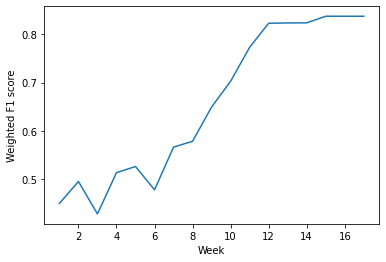

In [59]:
plt.figure()
plt.plot(Weeks, Week_Accuracy)
plt.xlabel('Week')
plt.ylabel('Weighted F1 score')
;

In [60]:
print('Highest accuracy: ',max(Week_Accuracy),"at Week",np.argmax(Week_Accuracy)+1)

Highest accuracy:  0.8377321344198715 at Week 15


# Predict outcomes for current season
Currently Season 12 is still running and we would like to see if we can predict the possible winners 

In [61]:
S12 = pd.read_csv('./Data/Season_12.csv',sep=',')

In [62]:
S_12_Predictions =  masterclassifier(Dataframe=Data,week_number=11,Output_12 = True, S_12=S12)

In [63]:
print(S_12_Predictions)
print("Accuracy at week 11 is : ",Week_Accuracy[10])

[3. 2. 1. 3. 0. 2. 2. 0. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Accuracy at week 11 is :  0.7733031494499385


In [64]:
First= S12[S12.columns[1]][(np.where(S_12_Predictions == 0))[0]]
Runner_up = S12[S12.columns[1]][(np.where(S_12_Predictions == 1))[0]]
Top_5 = S12[S12.columns[1]][(np.where(S_12_Predictions == 2))[0]]

In [65]:
print("Predicted first place: ",'\n',First)
print("Predicted Runner-up: ",'\n',Runner_up)
print("Predicted Top 5: ",'\n',Top_5)

Predicted first place:  
 4      Laura
7    Reynold
Name: Name, dtype: object
Predicted Runner-up:  
 2    Emelia
8     Tessa
Name: Name, dtype: object
Predicted Top 5:  
 1    Callum
5       Poh
6     Reece
Name: Name, dtype: object
